In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
from sklearn import preprocessing

In [30]:
def pie_chart(dataframe, title):
  counts = data['Topic'].value_counts()

  spacing = 1.01
  wedgeprops = {'width': spacing, 'edgecolor': 'w'}
  colors = ['#47b39c', '#ffc154', '#ec6b56']
  counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', wedgeprops=wedgeprops)
  plt.title(title)
  plt.ylabel('')
  plt.show()


# Ucitavanje i analiza skupa podataka

In [34]:
data = pd.read_csv('../dataset/train.csv')
rows, columns = data.shape
print(f'Num of rows: {rows}')
print(f'Num of columns: {columns}')
print(f'The dataset has the following attribute names: {list(data.columns)}')

Num of rows: 8695
Num of columns: 3
The dataset has the following attribute names: ['Id', 'Comment', 'Topic']


In [35]:
pd.options.display.max_colwidth = 1000
data.head()

#data.drop('Id', axis=1, inplace=True)

,Id,Comment,Topic
0,0x840,"A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food. So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating selection where al...",Biology
1,0xbf0,Is it so hard to believe that there exist particulars out that that we can't detect with anything we've invented so far.\n\nI mean look how long it took humans to find out a way to detect radiation.,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot of drugs on your liver. You probably won't die immediately you'll be fine. Take care of your self tho that's definitely not good for your body,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry



*   Id - nebitan atribut, uklanjanje
*   Comment - atibut po kome se vrsti klasifikacija
*   Topic - ciljna kategorija

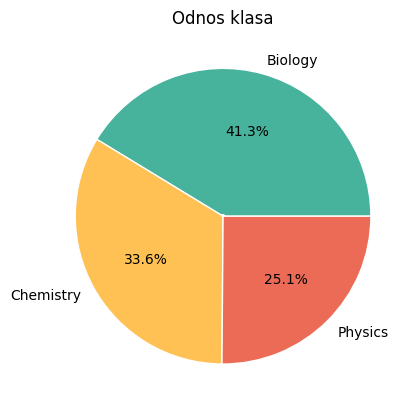

In [36]:
pie_chart(data, 'Odnos klasa')

#Elementi van granica

Text(0.5, 1.0, 'Biology')

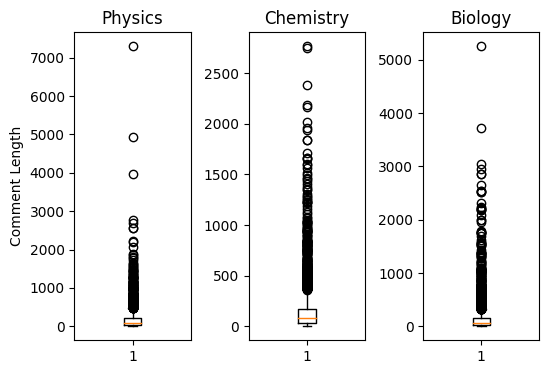

In [37]:
comments = data['Comment']
topics = data['Topic']

comment_lengths = comments.str.len()

physics_lengths = sorted(comment_lengths[topics == 'Physics'])
chemistry_lengths = sorted(comment_lengths[topics == 'Chemistry'])
biology_lengths = sorted(comment_lengths[topics == 'Biology'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.boxplot(physics_lengths)
plt.title('Physics')
plt.ylabel('Comment Length')

plt.subplot(1, 3, 2)
plt.boxplot(chemistry_lengths)
plt.title('Chemistry')

plt.subplot(1, 3, 3)
plt.boxplot(biology_lengths)
plt.title('Biology')

Reci koje se nalazi u veoma dugackim komentarima mogu visestruko da uticu na mogucnost generalizacije algoritama. Ukoliko se javljaju samo u tim instancama, bice oznacene kao znacajne za tu klasu, iako ne znamo da li su domenske reci niti da li se mogu naci u skupu predvidjenom za testiranje. Dodatno, povecavaju sam recnik sto moze dovesti do preprilagodjavanja. 

Jasni elementi van granica bi bile duzine vece od 3000, 2500, 3000, za fiziku, hemiju, biologiju, tim redosledom. Za klasu hemija veoma mali broj instanci je veci i od 2000, te spustamo granicu. U slucaju klase biologija imamo relativno veliki broj podataka u segmentu [2000, 3000]. Medjutim kako u trening skupu ta klasa cini 41% svih instanci i ovde pomeramo granicu na 2000 radi bolje balansiranosti i uniformnije raspodele. Fizika ostaje nepromenjena jer ima najmanju zastupljenost u treningu sa 25.1% ukupnih podataka, te se ovde izbacuju samo jasni outlajeri.

In [38]:
data = data.loc[~((data['Topic'] == 'Biology') & (data['Comment'].str.len() > 2000))]
data = data.loc[~((data['Topic'] == 'Chemistry') & (data['Comment'].str.len() > 2000))]
data = data.loc[~((data['Topic'] == 'Physics') & (data['Comment'].str.len() > 3000))]

rows, columns = data.shape
print(f'Num of rows: {rows}')
print(f'Num of columns: {columns}')

Num of rows: 8667
Num of columns: 3


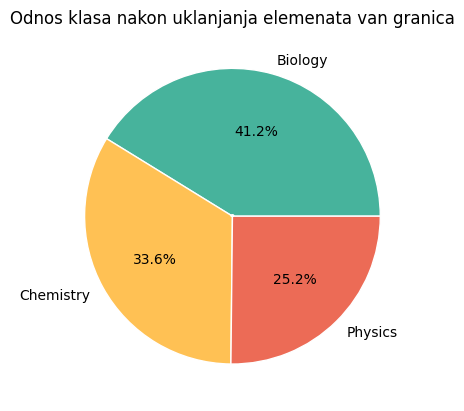

In [39]:
pie_chart(data, 'Odnos klasa nakon uklanjanja elemenata van granica')

In [40]:
comments = data['Comment']
topics = data['Topic']

comment_lengths = comments.str.len()

physics_lengths = sorted(comment_lengths[topics == 'Physics'])
chemistry_lengths = sorted(comment_lengths[topics == 'Chemistry'])
biology_lengths = sorted(comment_lengths[topics == 'Biology'])

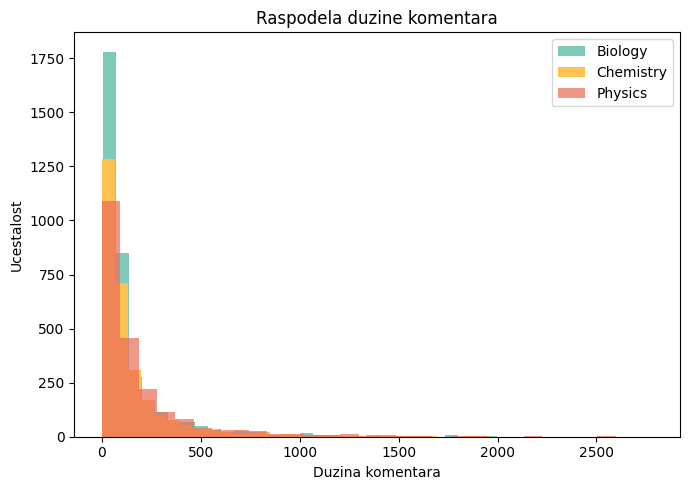

In [41]:
plt.figure(figsize=(7, 5))

plt.hist(biology_lengths, bins=30, color='#47b39c', alpha=0.7, label='Biology')
plt.hist(chemistry_lengths, bins=30, color='#ffc154', alpha=1, label='Chemistry')
plt.hist(physics_lengths, bins=30, color='#ec6b56', alpha=0.7, label='Physics')

plt.title('Raspodela duzine komentara')
plt.xlabel('Duzina komentara')
plt.ylabel('Ucestalost')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
all_comments = [biology_lengths, chemistry_lengths, physics_lengths]
classes = ['Biology', 'Chemistry', 'Physics']

metrics = []
for comments in all_comments:
    metrics.append({
        'mean': np.mean(comments),
        'median': np.median(comments),
        'std_dev': np.std(comments),
        'range': np.ptp(comments)
    })
    
for i, metric in enumerate(metrics):
    print(f"Category {classes[i]} Metrics:")
    print("Mean:", metric['mean'])
    print("Median:", metric['median'])
    print("Standard Deviation:", metric['std_dev'])
    print("Range:", metric['range'])
    print()

Category Biology Metrics:
Mean: 148.234882418813
Median: 71.0
Standard Deviation: 225.16344687575898
Range: 1994

Category Chemistry Metrics:
Mean: 152.82498284145504
Median: 78.0
Standard Deviation: 221.61984982950423
Range: 1955

Category Physics Metrics:
Mean: 190.54653828519028
Median: 93.0
Standard Deviation: 288.0102385960603
Range: 2782



#Rad sa nedostajucim vrednostima

In [43]:
data.isna().any().any()

False

Ustanovili smo da nema pristunih null ili NaN vrednosti. Ipak, imajuci u vidu da je ovo neprocesiran skup podataka sacinjen od komentara sa drustvene mreze, neke druge reci ili izrazi bi mogli biti indikatori nedostajuce vrednosti.<br> U okviru Reddit platforme, termini  **"[removed]"** i **"[deleted]"** oznacavaju uklanjanje i brisanje komentara. Dodatno, prisustvo "[removed]" oznacava da su moderatori uklonili odgovarajuci komentar, sto cesto implicira da je originalni komentar sadrzao uvredljiv sadrzaj, kontroverzna misljenja ili je prekrsio smernice zajednice u kojoj je pokrenuta diskusija. Sa druge strane, kada je prisutan termin "[deleted]", to sugerise da je korisnik dobrovoljno odlucio ga ukloni. U oba slucaja, pojava ovih termina je izolovana, bez bilo kakvih dodatnih znakova ili reci u komentaru. 

In [44]:
data.isin(['[removed]']).any().any()

True

In [45]:
data.isin(['[deleted]']).any().any()

True

In [46]:
count_removed = (data['Comment'] == '[removed]').sum()
count_deleted = (data['Comment'] == '[deleted]').sum()

removed_rows = data[data['Comment'] == '[removed]']
deleted_rows = data[data['Comment'] == '[deleted]']

In [47]:
deleted_rows

,Id,Comment,Topic
46,0x1a29,[deleted],Chemistry
162,0x1a1d,[deleted],Biology
316,0x1725,[deleted],Physics
422,0x32,[deleted],Physics
539,0x2d8,[deleted],Physics
...,...,...,...
7835,0x2550,[deleted],Chemistry
7913,0x20a0,[deleted],Biology
7949,0xda8,[deleted],Physics
8056,0x1cf8,[deleted],Biology


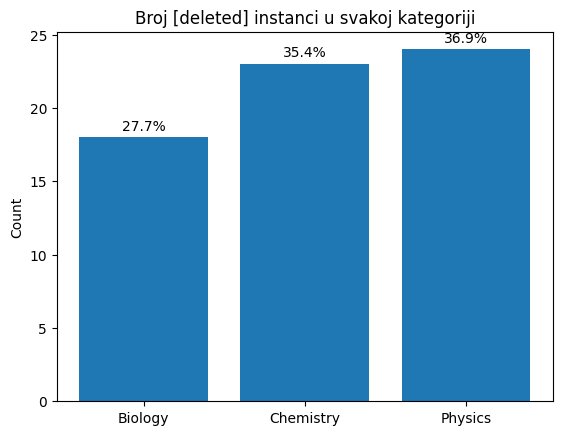

In [48]:
grouped_df = deleted_rows.groupby('Topic').size().reset_index(name='Count')
grouped_df['Percentage'] = (grouped_df['Count'] / count_deleted) * 100

plt.bar(grouped_df['Topic'], grouped_df['Count'])
plt.ylabel('Count')
plt.title('Broj [deleted] instanci u svakoj kategoriji')

for i, count in enumerate(grouped_df['Count']):
    percentage = grouped_df.loc[i, 'Percentage']
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center')
    
plt.show()

In [49]:
removed_rows

,Id,Comment,Topic
36,0x1b1,[removed],Physics
84,0x1804,[removed],Physics
86,0x1fea,[removed],Physics
108,0x819,[removed],Physics
115,0x12dd,[removed],Physics
...,...,...,...
8201,0x220d,[removed],Physics
8355,0xe36,[removed],Physics
8394,0x242f,[removed],Physics
8421,0x19d1,[removed],Physics


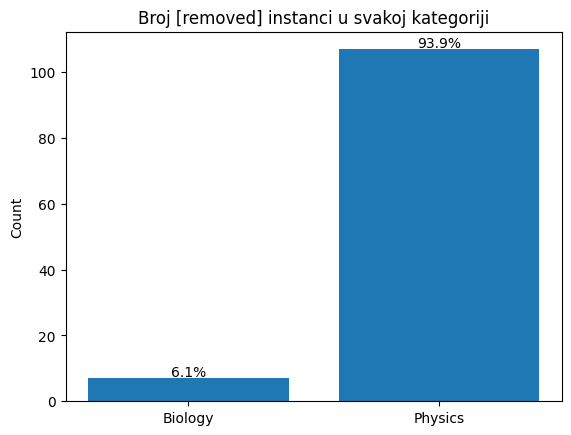

In [50]:
grouped_df = removed_rows.groupby('Topic').size().reset_index(name='Count')
grouped_df['Percentage'] = (grouped_df['Count'] / count_removed) * 100


plt.bar(grouped_df['Topic'], grouped_df['Count'])
plt.ylabel('Count')
plt.title('Broj [removed] instanci u svakoj kategoriji')

for i, count in enumerate(grouped_df['Count']):
    percentage = grouped_df.loc[i, 'Percentage']
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center')

plt.show()

Imamo ukupno 179 nedostajucih vrednosti, od kojih 65 predstavlja obrisane komentare, a 114 uklonjene. <br>Skup obrisanih komentara pokazuje pretezno ujednacenu distribuciju po klasama, uz blagu naklonjenost ka fizici. Konkretno, sastoji se od 27,7% biologije, 35,4% hemije i 36,9% fizike.<br>
Sa druge strane, skup ukljonjenih komentara ima malo interesantniji obrazac sa znacajno razlicitim raspodelama po klasama. Konkretno, biologija cini 6.1% podataka, dok fizika dominira sa znatnom vecinom od 93.3%. Primetno, nijedan uklonjen komentar se ne odnosi na kategoriju hemije. Ovo implicira da su diskusije vezane za biologiju manje sklone ukljanjaju u poredjenju sa fizikom. Dodatno, velika zastupljenost fizike ukazuje na vecu verovatnocu kontroverznih diskusija u tom domenu, koje mogu dovesti do preterano neprimernog izrazavanja ili krsenja smernica zajednice. Nasuprot tome, odusustvo komentara u kategoriji hemije moze ukazati na manju ucestalost polarizujucih tema u toj oblasti.

Iako je verovatno da je ovakva raspodela indkuvana kolicinom kontroverznih tema ili misljenja u sklopu svake od ove tri oblasti, ne treba iskljuciti mogucnost da su razlicite smernice u svakoj od zajednica, i da moderatori nemaju isti stepen prihvatljivosti misljenja ili neprimernog sadrzaja.

In [51]:
data = data.drop(data[(data['Comment'] == '[removed]') | (data['Comment'] == '[deleted]')].index)

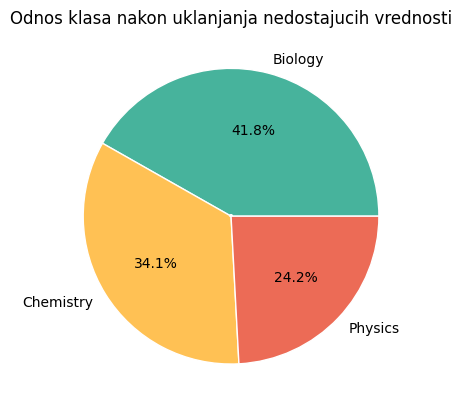

In [52]:
pie_chart(data, 'Odnos klasa nakon uklanjanja nedostajucih vrednosti')

# Pretprocesiranje

In [33]:
file_path = "common_words.txt"  
with open(file_path, 'r') as file:
    additional_stop_words = [line.strip() for line in file]

Kao sto je vec napomenuto, nasi komentari su sirovi. Neophodno je uraditi preprocesiranje koje ima za cilj da poboljsalj kvalitet reprezentacije skupa pre primene TF-IDF matrice. Primenjujemo sledeci niz koraka na svaki od komentara:

> **1.Mala slova:** Ceo tekst je konvertovan u mala slova da bi se obezbedila neosetljivost na mala i velika slova. Ne zelimo da 'fizika' i 'Fizika' gledamo kao dva razlicita tokena. <br>

'FiZika' -> 'fizika' <br>

> **2.   Filtriranje reci:** Zadrzavamo samo slova, zamenjujuci belinama brojeve, simbole i znakove interpunkcije.  <br>

'fizika!' -> 'fizika '<br>
'reci, sa, znakovima . ' -> 'reci  sa  znakovima   ' <br>

> **3. Uzastopno ponavljanje:** Reci koje sadrze slovo ponovljeno vise od dva puta uzastopno bice eliminisane. Ove reci su sum jer je u engleskom jeziku najveci broj uzastopnog ponavljanja karaktera jednak dva. <br>

'physicsss' -> '' <br>

> **4. Tokenizacija:** Deljenje recenice na pojedinacne reci ili lekseme, koristeci razmak kao separator. <br>

'ovo je recenica' -> 'ovo', 'je', 'recenica' <br>

> **5. Stop words:** Skup reci koji se veoma cesto koristi u jeziku, kao sto su predlozi i zamenice se uklanjaju jer uglavnom dodaju malo kontekstualnih informacija. Kao i kod prethodnog koraka, predstavljaju sum. <br>

'there are bees' -> 'bees'<br>

> **6. Lematizacija:** Skracivanje reci do njihovog korena ili osnovnog oblika u recniku. Zelimo da razliciti i izvedeni oblici iste reci budu jedan token. <br>

'run' -> 'run' <br>
'running' -> 'run'<br>

> **7. Minimalna duzina:** Odbacivanje tokena manjih od 3 karaktera, jer verovatno nisu smisleni i znacajni.<br>

'to' -> ''



Napomena: u praksi se cesto uklanjaju linkovi. Ovde to nije uradjeno, jer je moguce da su prosledjene domenski specificne stvari, kao sto su naucni clanci, koji bi mogli u svom nazivu da sadrze bitne termine.

In [54]:
def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile(r'[^A-Za-z \']+')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r"\b\d+\b", "", cleantext)
    cleantext = re.sub(r'\b\w*([a-zA-Z])\1{2,}\w*\b', "", cleantext)
     
    common_stopwords = set(stopwords.words('english'))
    common_stopwords.update(['http', 'https', 'www', 'com', 'yeah'])
    common_stopwords.update(additional_stop_words)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(cleantext)
    
    tokens = [t for t in tokens if not t in common_stopwords]
    
    lemmatizer = WordNetLemmatizer()   
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    tokens = [token for token in tokens if len(token) >= 3]
    
    return tokens

Uporedni prikaz podataka pre i nakon obrade

In [55]:
df = data.copy()
df["Processed Comments"] = df["Comment"].apply(preprocess).apply(lambda x: " ".join(x))

df_show = df.drop('Id', axis=1)
df_show = df_show.drop('Topic', axis=1)
df_show.head(10)

,Comment,Processed Comments
0,"A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food. So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating selection where al...",thing negative frequency dependent selection common phenotype reflected genotype advantage environment instance prey animal vole dark phenotype predator recognize common phenotype food vole common fox keeping closer eye phenotypic vole recognising prey reduce causing allele due increased predation dark genotype increase proportion population scenario reversed cycle continues perpetually nhowever unlikely strictly yearly take entire population allele frequency large difference alter fitness nmore basis population experiencing fluctuating selection alternating condition environment favor genotype perhaps plant specie living area flooded phenotype population plant dryer wet flooding dry genotype fitness leading offspring therefore dry allele population flooded year wet liking phenotype propagate wet gene
1,Is it so hard to believe that there exist particulars out that that we can't detect with anything we've invented so far.\n\nI mean look how long it took humans to find out a way to detect radiation.,exist particular detect invented took human detect radiation
2,There are bees,bee
3,I'm a medication technician. And that's alot of drugs on your liver. You probably won't die immediately you'll be fine. Take care of your self tho that's definitely not good for your body,medication technician alot drug liver die immediately fine care self tho
4,Cesium is such a pretty metal.,cesium metal
5,I meant that the question itself is unclear.,meant unclear
6,Shove it up your ass and see what happens,shove happens
7,"??? I mean it has some butter, but besides that it’s sugar, baking soda, and peanuts, so yeah…",butter besides sugar baking soda peanut
8,https://t.me/joinchat/3gElLHLuMCxhNGI0,joinchat gellhlumcxhngi
9,"Well, that’s just the thing. You can’t really induce an immune response against yourself by introducing a protein that’s already there.",induce immune response introducing protein


# TF IDF matrica

Da bismo omogucili primenu algoritama koji obicno rade na numerickim podacima, transformisacemo podatke iz stringovne u numericku reprezentaciju koristeci Term Frequency-Inverse Document Frequency matricu. TF IDF matrica svakom tokenu dodeljuje vrednost, i obuhvata vaznost termina u odnosu na dokument (komentar) u kome se pojavljaje, kao i njegovu relevantnost u sirem kontekstu citavog skupa podataka.<br>
Zbog efikasnijeg izvrsavanja i prevelike kolicine reci u recniku, ogranicavamo broj atributa na 8000.
<br>
Dodatno, enkodiramo ciljnu promenljivu Topic.
> ['Biology', 'Chemistry', 'Physics'] -> [0, 1, 2]

In [56]:
le = preprocessing.LabelEncoder()
y=data['Topic']
y=le.fit_transform(y)

vectorizer = TfidfVectorizer(max_features=8000)
tfidf_matrix = vectorizer.fit_transform(df["Processed Comments"])

# izvlacenje imena kolona
tfidf_feature_names = vectorizer.get_feature_names_out()

# konacna reprezentacija za model
tfidf_df = pd.concat([pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names),
                             pd.DataFrame(y)], axis=1)

tfidf_df.head(10)

,aaronson,aat,abdomen,abduction,ability,abomination,abrasive,abroad,absence,absent,...,zerg,zero,zhu,zika,zinc,zone,zoom,ztsi,zurich,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [57]:
tfidf_df.to_csv('train_data.csv', index=False)

#Primena transformacija na test skup

Na isti nacin obradjujemo podatke u test skupu, uz napomenu da za transformaciju u TF IDF matricu koristimo vectorizer naucen na trening podacima da ne bi doslo do prilagodjavanja nepoznatim podacima.

In [58]:
test_data = pd.read_csv('../dataset/test.csv')

In [59]:
rows, columns = test_data.shape
print(f'Num of rows: {rows}')
print(f'Num of columns: {columns}')

Num of rows: 1586
Num of columns: 3


In [60]:
test_df = test_data.copy()

In [61]:
test_df["Processed Comments"] = test_df["Comment"].apply(preprocess).apply(lambda x: " ".join(x))

In [62]:
y=test_df['Topic']
y=le.fit_transform(y)
tfidf_test_matrix = vectorizer.transform(test_df["Processed Comments"])

test_tfidf_feature_names = vectorizer.get_feature_names_out()

test_tfidf_df = pd.concat([pd.DataFrame(tfidf_test_matrix.toarray(), columns=test_tfidf_feature_names),
                             pd.DataFrame(y)], axis=1)

test_tfidf_df.to_csv('test_data.csv', index=False)